# Project 3a: Self-Attention and Transformers

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers.models.mbart50.tokenization_mbart50_fast import MBart50Tokenizer

## 1.1: Implementing Self-Attention from Scratch

This assignment is adapted from the code by Yegor Kuznetsov, Liwei Jiang, and Jaehun Jung.

## Preparation

In [2]:
######################################################
#  The following code is given to you.
######################################################


def MHA_wrapper(query, key, value, n_heads=1, causal=False):
    """
    This is a wrapper around the PyTorch implementation of multi-head attention.
    You will use this implementation to compare to your implementation for code testing.
    """
    assert query.shape == key.shape == value.shape
    _, n_tok, n_embd = query.shape

    query = query.transpose(0, 1)
    key = key.transpose(0, 1)
    value = value.transpose(0, 1)

    in_proj_weight = torch.eye(n_embd, dtype=key.dtype, device=key.device).repeat(
        (3, 1)
    )
    out_proj_weight = torch.eye(n_embd, dtype=key.dtype, device=key.device)

    attn_mask = None
    if causal:
        attn_mask = torch.tril(
            torch.ones(n_tok, n_tok, dtype=bool, device=key.device)
        ).logical_not()

    out, _ = F.multi_head_attention_forward(
        query,
        key,
        value,
        n_embd,
        n_heads,
        in_proj_weight=in_proj_weight,
        in_proj_bias=None,
        bias_k=None,
        bias_v=None,
        add_zero_attn=False,
        dropout_p=0,
        out_proj_weight=out_proj_weight,
        out_proj_bias=None,
        attn_mask=attn_mask,
        need_weights=False,
    )

    return out.transpose(0, 1)

In [3]:
######################################################
#  The following code is given to you.
######################################################

# use cpu for now
DEVICE = "cpu"

# make these bigger if you want a stricter test of your code
part1_n_tok = 10
part1_n_emb = 6

# generate fixed pseudo-random Q,K,V for testing attn function
torch.manual_seed(447)

# Initialize random testing Q,K,V
part1_key = torch.randn(1, part1_n_tok, part1_n_emb)
part1_value = torch.randn(1, part1_n_tok, part1_n_emb)
part1_query = torch.randn(1, part1_n_tok, part1_n_emb)

## Step 0: Set up the projections for attention.
**You will complete the following code blocks denoted by `TODO:`.** For now you don't need to implement anything here, as you go through the following steps, you will keep coming back to this cell and fill in your implementation.

In [86]:
NUM_LAYERS = 1 # global variable for small_fc method

In [34]:
def init_qkv_proj(n_embd: int):
    """
    This function is given to you.
    :return: A tuple of length 3 containing the projections for Q, K, V.
    """
    return (
        small_fc(n_embd),
        small_fc(n_embd),
        small_fc(n_embd)
    )

def small_fc(n_embd: int):
    layers = [
        layer 
        for _ in range(NUM_LAYERS)
        for layer in (nn.Linear(n_embd, n_embd), nn.ReLU())
    ]
    layers.append(nn.Linear(n_embd, n_embd))
    
    return nn.Sequential(*layers)

def self_attention(Q, K, V, n_heads=1, causal=True):
    """
    Self-attention block.

    Note: You will keep coming back to this cell and fill in more of this function
    after completing each of the following steps! Don't forget to re-run this
    cell each time you change it. Make sure that once you're done, all the testing
    cells should work.

    :return: A tensor containing the result of the self-attention operation.

    """
    
    assert Q.shape == K.shape == V.shape
    B, n_tok, n_embd = Q.shape
    
    # TODO: Step 3 -- split heads
    if n_heads > 1:
        # YOUR CODE HERE
        Q, K, V = split_heads_qkv(Q, K, V, n_heads)
    
    # TODO: Step 1 -- Calculate raw attention scores, i.e., before softmax
    # Hint: you need two lines here.
    # YOUR CODE HERE
    A = pairwise_similarities(Q, K)
    A = attn_scaled(A, n_embd, n_heads)

    # TODO: Step 2 -- create and apply the causal mask to attention.
    if causal:
        # YOUR CODE HERE
        M = make_causal_mask(n_tok)
        A = apply_causal_mask(M, A)

    # TODO: Step 1 -- softmax the raw attention and use it to get outputs.
    # Hint: you need two lines here.
    A = attn_softmax(A)
    y = compute_outputs(A, V)
    # YOUR CODE HERE
    # TODO: Step 3 -- merge heads.
    if n_heads > 1:
        # YOUR CODE HERE
        y = merge_heads(y)
    # output should have the same shape as input
    assert y.shape == (B, n_tok, n_embd)
    return y

## Step 1: Implement the core components of attention.

Note that a self attention block consists of the following computations:

Given a set of query vectors $Q$, key vectors $K$, and value vectors $V$,

Compute the raw attention scores $A$ as:
$$ A = \frac{1}{\sqrt{d_{\text{head}}}}QK^T $$

Apply a softmax to the scaled scores to get the attention weights:
$$ A = \texttt{softmax} (A) $$

Compute the output vectors by taking a weighted sum of the value vectors, weighted by the attention weights:
$$ O = AV $$

Note that $d_{\text{head}}$ is the dimensionality of the feature vectors i.e. query, key, and value vectors and is given by $\frac{d_{\text{model}}}{n_{\text{heads}}}$, where $d_{\text{model}}$ is the embedding dimension of the model and $n_{\text{heads}}$ is the number of attention heads.


Useful tips:
- You can use the `@` operator to perform matrix multiplication. Alternatively, you can use the `torch.matmul` function.
- For the batched cases, for e.g., you have a tensor X of shape (B, m, n) and another tensor Y of shape (B, n, m), then X@Y performs the matrix multiplication for each of the batch elements, giving you a tensor of shape (B, m, m).
- You can use the `transpose` method to transpose matrices in pytorch. If you have a tensor X of shape (B, n, m), then X.transpose(-2, -1) gives you a tensor of shape (B, m, n).
- You might find the `F.softmax` function useful. Check the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html) for more details.
- Softmax is applied along the last dimension.

**You will complete the following code blocks denoted by `TODO:`.**

In [5]:
def pairwise_similarities(Q, K):
    """
    Dot product attention is computed via the dot product between each query and each key.

    Inputs:
    - Q: torch.Tensor, shape (B, n_tok, n_embd) or (B, n_heads, n_tok, n_embd) containing the queries, where B is the batch size, n_heads is the number of attention heads, n_tok is the number of tokens, and n_embd is the embedding dimension.
    - K: torch.Tensor, shape (B, n_tok, n_embd) or (B, n_heads, n_tok, n_embd) containing the keys, where B is the batch size, n_heads is the number of attention heads, n_tok is the number of tokens, and n_embd is the embedding dimension.

    :return: The raw attention scores, A = QK^T.
    """
    # TODO:
    # YOUR CODE HERE
    return Q @ K.transpose(-2, -1)

def attn_scaled(A, d_model: float, n_heads: float):
    """
    Scale the raw attention scores.
    Inputs:
    - A: torch.Tensor, shape (B, n_tok, n_tok) or (B, n_heads, n_tok, n_tok) containing the raw attention scores, where B is the batch size, n_heads is the number of attention heads, n_tok is the number of tokens.
    - d_model: int, the embedding dimension.
    - n_heads: int, the number of attention heads.
    :return: Scaled raw attention scores.

    """
    # TODO:
    # YOUR CODE HERE
    d_head = d_model // n_heads
    return A / math.sqrt(d_head)

def attn_softmax(A):
    """
    Normalize the scaled raw attention scores with softmax.
    Inputs:
    - A: torch.Tensor, shape (B, n_tok, n_tok) or (B, n_heads, n_tok, n_tok) containing the scaled raw attention scores, where B is the batch size, n_heads is the number of attention heads, n_tok is the number of tokens.
    :return: Normalized attention scores, A' = softmax(A).
    """
    # TODO:
    # YOUR CODE HERE
    return F.softmax(A, dim=-1)

def compute_outputs(A, V):
    """
    Get outputs as a weighted sum of values by attention scores, using matrices.
    Inputs:
    - A: torch.Tensor, shape (B, n_tok, n_tok) or (B, n_heads, n_tok, n_tok) containing the normalized attention scores, where B is the batch size, n_heads is the number of attention heads, n_tok is the number of tokens.
    - V: torch.Tensor, shape (B, n_tok, n_embd) or (B, n_heads, n_tok, n_embd) containing the value vectors, where B is the batch size, n_heads is the number of attention heads, n_tok is the number of tokens, and n_embd is the embedding dimension.
    :return: weighted sum of values by attention scores.
    """
    # TODO:
    # YOUR CODE HERE
    return A @ V

## Test 1: Building Single-headed Self-attention without Masking

Implement lines denoted by `Step 1` in `self-attention()`, and run the following test code to verify your implementation produces close enough results to the PyTorch implementation.

In [6]:
######################################################
#  The following code is given to you. DO NOT MODIFY.
######################################################

out_A = self_attention(part1_query, part1_key, part1_value, n_heads=1, causal=False)
out_B = MHA_wrapper(part1_query, part1_key, part1_value, n_heads=1, causal=False)
assert out_A.shape == out_B.shape == part1_query.shape

print("max diff:", (out_A - out_B).abs().max().item())

max diff: 1.4901161193847656e-07


Max difference should be very small, our reference implementation gets a difference of the order of 1e-7

## Step 2: Implement causal masking for language modeling.

Note that for language modeling, since we are predicting the next token at every step, we cannot attend to future tokens. Therefore, we need to apply a causal mask to the attention scores, which is a lower triangular matrix, i.e., all the values above the diagonal are set to zero. Hence, the model can attend to the current and past tokens only.

Useful tips:

- Note that the mask is applied to the attention scores **before** the softmax operation.
- A 0 raw attention score (pre-softmax) doesn't mean that after applying softmax it will also be 0! Think what score should be used to represent a raw attention score so that when softmaxed it will be 0.
- You might find the `masked_fill` method useful. Check the [documentation](https://pytorch.org/docs/stable/generated/torch.Tensor.masked_fill.html) for more details.

**You will complete the following code blocks denoted by `TODO:`.**

In [7]:
def make_causal_mask(n_tok: int):
    """
    Create a mask matrix that masks future context for the attention.
    Inputs:
    - n_tok: int, the number of tokens in the sequence.
    :return: A mask matrix which is a tensor of shape (n_tok, n_tok)
    """
    # TODO:
    # YOUR CODE HERE
    ones_matrix = torch.ones(n_tok, n_tok, dtype=torch.bool)
    return torch.triu(ones_matrix, diagonal=1)
    
def apply_causal_mask(mask, A):
    
    """
    Apply mask to attention.
    Inputs:
    - mask: torch.Tensor, shape (n_tok, n_tok) containing the causal mask.
    - A: torch.Tensor, shape (B, n_tok, n_tok) or (B, n_heads, n_tok, n_tok) containing the attention scores, where B is the batch size, n_heads is the number of attention heads, n_tok is the number of tokens.
    :return: A masked attention matrix.
    """
    # TODO:
    # YOUR CODE HERE
    # if mask is on the wrong device
    mask = mask.to(A.device)
    return A.masked_fill_(mask, float('-inf'))

## Test 2: Adding Causal Masks

Implement lines denoted by `Step 2` in `self-attention()`, and run the following test code to verify your implementation produces close enough results to the PyTorch implementation.

In [8]:
out_A = self_attention(part1_query, part1_key, part1_value, n_heads=1, causal=True)
out_B = MHA_wrapper(part1_query, part1_key, part1_value, n_heads=1, causal=True)
assert out_A.shape == out_B.shape == part1_query.shape

print("max diff:", (out_A - out_B).abs().max().item())

max diff: 1.1920928955078125e-07


The max difference should be very small, our reference implementation gets a difference of the order of 1e-7

## Step 3: Implement multi-head attention.

Recall from the lecture that multi-head attention is implemented by running self-attention independently on each head and then concatenating the results. Specifically, we use the following steps:

1. Split the queries, keys, and values into multiple heads.
$$ Q = [Q_1, Q_2, \ldots, Q_{n_{\text{heads}}}], K = [K_1, K_2, \ldots, K_{n_{\text{heads}}}], V = [V_1, V_2, \ldots, V_{n_{\text{heads}}}] $$
where $n_{\text{heads}}$ is the number of heads. This is done by simply splitting the embedding dimension into $n_{\text{heads}}$ chunks.

2. Run self-attention independently on each head.
$$ O_i = \text{self\_attention}(Q_i, K_i, V_i, n_{\text{heads}}=n_{\text{heads}}, causal=causal) $$
for $i=1, 2, \ldots, n_{\text{heads}}$.
Note that you don't actually need to call the self-attention function separately for each head. If your implementation is correct, you should be able to perform a single call to self_attention with the split Q, K, and V and get the same result.

3. Concatenate the results of the heads.
$$ O = \text{concat}(O_1, O_2, \ldots, O_{n_{\text{heads}}}) $$

Useful tips:
- You might find the `.view` method useful for splitting and merging heads. Check the [documentation](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html) for more details.
- You might find the `.contiguous()` method useful for merging heads. Check the [documentation](https://pytorch.org/docs/stable/generated/torch.Tensor.contiguous.html) for more details.

**You will complete the following code blocks denoted by `TODO:`.**

In [9]:
def split_heads_qkv(Q, K, V, n_heads: int):
    """
    Provided as a utility -- you can choose to not use it if you'd like.
    """
    return split_heads(Q, n_heads), split_heads(K, n_heads), split_heads(V, n_heads)


def split_heads(x, n_heads: int):
    """
    Splitting x across multiple heads.
    Inputs:
    - x: torch.Tensor, shape (B, n_tok, n_embd) can be the queries, or keys, or values, where B is the batch size, n_tok is the number of tokens, and n_embd is the embedding dimension.
    - n_heads: int, the number of heads.
    :return: A split x, shape (B,n_heads, n_tok, n_embd // n_heads)
    """
    B, n_tok, n_embd = x.size()
    assert n_embd % n_heads == 0, "d must be divisible by number of heads"
    # TODO:
    # YOUR CODE HERE
    # .view() only works by (reversing) concat if dimensions are adjacent
    x = x.view(B, n_tok, n_heads, n_embd // n_heads)
    # changes x to (B, n_heads, n_tok, n_embd // n_heads)
    return x.transpose(1, 2)


def merge_heads(y: torch.Tensor):
    """
    Reversing splitting action of y.
    Inputs: 
    - y: torch.Tensor, shape (B, n_heads, n_tok, n_embd // n_heads)
    :return: A merged y, shape (B, n_tok, n_embd)
    """
    B, nh, n_tok, nc = y.size()
    # TODO:
    # YOUR CODE HERE
    # .view() only works by concat if dimensions are adjacent, and can only run if tensor is contiguous
    # makes y (B, n_tok, n_heads, n_embd // n_heads)
    y = y.transpose(1, 2)
    return y.contiguous().view(B, n_tok, nc * nh)


## Test 3: Adding Multi-Head Attention

Implement lines denoted by `Step 3` in `self-attention()`, and run the following test code to verify your implementation produces close enough results to the PyTorch implementation.

In [10]:
######################################################
#  The following code is given to you. DO NOT MODIFY.
######################################################

out_A = self_attention(part1_query, part1_key, part1_value, n_heads=3, causal=True)
out_B = MHA_wrapper(part1_query, part1_key, part1_value, n_heads=3, causal=True)
assert out_A.shape == out_B.shape == part1_query.shape

print("max diff:", (out_A - out_B).abs().max().item())

max diff: 1.1920928955078125e-07


The max difference should be very small, our reference implementation gets a difference of the order of 1e-7

## 1.2: Experiment with Your Transformer

In this part, you will train a transformer-based language model. We will provide you the starter code for training the model and evaluating perplexity on a dataset. You will then explore changes to the network architecture and see how they affect the training and performance of the language model.

**Note: We will NOT grade this part of the assignment.** This is an open-ended exercise. The following codes provide you with a basis to experiment with some perspectives of your attention block, and you will summarize your explorations in the write-up. We will only grade the write-up for part 2.2.

## Preparation: Modifications to Your Attention Implementation for section 2.2

Below is space for you to work on a *modified* version of your attention implementation above for your experimentation in section 2.2. **Ensure your submitted code does not break the tests in section 2.1**; the easiest way to do this is to *copy* your implementation above (and probably condense it) and modify it below. We provide you pointers on what explorations you can do in the handout.

You can also put any code anywhere in section 2.2; putting that code here is just a suggestion.

In [11]:
# TODO: Have your modified attention implementation here.
# YOUR CODE HERE

def split_heads_qkv(Q, K, V, n_heads: int):
    """
    Provided as a utility -- you can choose to not use it if you'd like.
    """
    return split_heads(Q, n_heads), split_heads(K, n_heads), split_heads(V, n_heads)


def split_heads(x, n_heads: int):
    """
    Splitting x across multiple heads.
    Inputs:
    - x: torch.Tensor, shape (B, n_tok, n_embd) can be the queries, or keys, or values, where B is the batch size, n_tok is the number of tokens, and n_embd is the embedding dimension.
    - n_heads: int, the number of heads.
    :return: A split x, shape (B,n_heads, n_tok, n_embd // n_heads)
    """
    B, n_tok, n_embd = x.size()
    assert n_embd % n_heads == 0, "d must be divisible by number of heads"
    # TODO:
    x = x.view(B, n_tok, n_heads, n_embd // n_heads)
    x = x.transpose(1, 2)
    return x


def merge_heads(y):
    """
    Reversing splitting action of y.
    Inputs:
    - y: torch.Tensor, shape (B, n_heads, n_tok, n_embd // n_heads)
    :return: A merged y, shape (B, n_tok, n_embd)
    """
    B, nh, n_tok, nc = y.size()
    
    y = y.transpose(1, 2)
    y = y.contiguous().view(B, n_tok, nh * nc)
    return y

## Guideline for Section 1.2

What follows is the **starter code** for section 1.2. It includes the following:
- Download the ngram data from Project 1
- Download the fork of minGPT by Yegor, modified to receive an implementation of attention from an external source (i.e., this notebook)
- Simple implementation of tokenization which is very similar to what you did for Project 1. Differences from Project 1:
    - include `<START>` in the vocab
    - truncate to a fixed maximum sequence length of 100 tokens
    - pad with `<PAD>` to the max length
- `<PAD>` is new -- the loss is set to ignore anything with this token, such that the model doesn't get optimized for learning how to pad, and instead gets trained for the actual text.
- Model initialization is set up, but has not been tuned. Feel free to modify anything about it.
- Simple trainer code to loop over the data and optimize on the model. We included a nice progress bar for you to watch while waiting.
    - On the free-tier GPU in Colab, our provided starter code trains for an epoch (less than 2000 steps) within a few minutes. On CPU, it takes over an hour for even the smallest configuration.
- Demonstration/explanation of loss calculation.
- Per-document perplexity calculation like in Project 1, though it's a bit different:
    - Due to the max training length, the learned positional embeddings won't extrapolate past 100 tokens. So, we actually only test on a *truncated* version of the data
    - Most documents are less than 100 tokens and end up with a long chain of `<PAD>`s at the end. We don't want to include that in our loss/perplexity, so we show how to omit it from the calculation.
- minGPT defines a very convenient `generate` function. We have a few example prompts you can try with it -- take a look at the kind of text your trained model generates.

----

**Feel free to modify the starter code as much as you want to!** We will focus on your report and not your code for section 2.2, so change anything. In particular, you will want to add more analysis/logging/comparisons for anything that's relevant to your experiment. Of course, that is in addition to the changes on top of part 2.1, as needed.

### Utilities, data, and imports

In [12]:
%%bash
# We will use the Shakespeare dataset we used in Project 1.
mkdir -p data
wget https://homes.cs.washington.edu/~kahuja/cse447/project1/data/shakespear_train.txt -O data/shakespear_train.txt
wget https://homes.cs.washington.edu/~kahuja/cse447/project1/data/shakespear_dev.txt -O data/shakespear_dev.txt
wget https://homes.cs.washington.edu/~kahuja/cse447/project1/data/shakespear_test.txt -O data/shakespear_test.txt

--2024-12-05 14:20:04--  https://homes.cs.washington.edu/~kahuja/cse447/project1/data/shakespear_train.txt
Resolving homes.cs.washington.edu (homes.cs.washington.edu)... 128.208.3.226, 2607:4000:200:12::e2
Connecting to homes.cs.washington.edu (homes.cs.washington.edu)|128.208.3.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 943314 (921K) [text/plain]
Saving to: ‘data/shakespear_train.txt’

     0K .......... .......... .......... .......... ..........  5% 2.04M 0s
    50K .......... .......... .......... .......... .......... 10% 2.15M 0s
   100K .......... .......... .......... .......... .......... 16% 25.6M 0s
   150K .......... .......... .......... .......... .......... 21% 30.0M 0s
   200K .......... .......... .......... .......... .......... 27% 3.97M 0s
   250K .......... .......... .......... .......... .......... 32% 6.02M 0s
   300K .......... .......... .......... .......... .......... 37% 28.7M 0s
   350K .......... .......... .......... ..

In [13]:
%%bash
# clone Yegor's fork of minGPT and link to the code
[ -d "mingpt-cse447" ] || git clone https://gitlab.cs.washington.edu/yegork/mingpt-cse447.git
[ -e "mingpt" ] || ln -s mingpt-cse447/mingpt mingpt

In [14]:
import os
import requests
import subprocess
import shutil

# Ensure 'data' directory exists
os.makedirs("data", exist_ok=True)

# Download files
for name in ["train", "dev", "test"]:
    url = f"https://homes.cs.washington.edu/~kahuja/cse447/project1/data/shakespear_{name}.txt"
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(f"data/shakespear_{name}.txt", "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

# Clone repo and copy the directory
if not os.path.isdir("mingpt-cse447"):
    subprocess.run(["git", "clone", "https://gitlab.cs.washington.edu/yegork/mingpt-cse447.git"], check=True)
if not os.path.exists("mingpt"):
    shutil.copytree("mingpt-cse447/mingpt", "mingpt")

In [15]:
from mingpt.model import GPT
from mingpt.trainer import Trainer

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from collections import Counter
import numpy as np

### Dataset processing

In [16]:
%%bash
# recall that our data is just a text file of space-separated tokens, with new lines separating documents
cat data/shakespear_train.txt | head -n 10

First Citizen : Before we proceed any further , hear me speak .
All : Speak , speak .
First Citizen : You are all resolved rather to die than to famish ?
All : Resolved .
resolved .
First Citizen : First , you know Caius Marcius is chief enemy to the people .
All : We know't , we know't .
First Citizen : Let us kill him , and we 'll have corn at our own price .
Is't a verdict ?
All : No more talking o n't ; let it be done : away , away !


In [17]:
# Print the first 10 lines of a file
file_path = "data/shakespear_train.txt"

with open(file_path, "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        if i >= 10:  # Stop after 10 lines
            break
        print(line.strip())

First Citizen : Before we proceed any further , hear me speak .
All : Speak , speak .
First Citizen : You are all resolved rather to die than to famish ?
All : Resolved .
resolved .
First Citizen : First , you know Caius Marcius is chief enemy to the people .
All : We know't , we know't .
First Citizen : Let us kill him , and we 'll have corn at our own price .
Is't a verdict ?
All : No more talking o n't ; let it be done : away , away !


In [18]:
with open("data/shakespear_train.txt", "r") as f: lines_train = f.readlines()
with open("data/shakespear_dev.txt", "r") as f: lines_dev = f.readlines()
with open("data/shakespear_test.txt", "r") as f: lines_test = f.readlines()

# each element is a list of tokens
tokens_train = [line.split() for line in lines_train]

print(f"train docs: {len(tokens_train)}")
print(f"total train tokens: {sum(len(t) for t in tokens_train)}")


# utility fn to flatten the tokens structure
def flat(tokens):
    for t in tokens:
        yield from t

train docs: 9875
total train tokens: 206589


In [19]:
# get counts of each token sorted by count, descending
# also add a few special tokens (with high counts) so they appear first
token_counts = Counter(flat(tokens_train))
token_counts["<START>"] = 1000004
token_counts["<STOP>"] = 1000003
token_counts["<UNK>"] = 1000002
token_counts["<PAD>"] = 1000001
sorted_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)

print("unique_tokens:", len(token_counts))
print("unique_tokens, count>=3:", len([t for t in sorted_tokens if t[1] >= 3]))

# make tokenizer for all tokens with count >= 3
# note that our tokenizer ends up including START and STOP tokens too
tokenizer = {t[0]: i for i, t in enumerate(sorted_tokens) if t[1] >= 3}


def pad_to_length(tokens, max_len, tokenizer=tokenizer):
    return tokens[:max_len] + [tokenizer["<PAD>"]] * (max_len - len(tokens))


def tokenize(sentence, pad_to_len=None, include_stop=True, tokenizer=tokenizer):
    words = [tokenizer.get(w, tokenizer["<UNK>"]) for w in sentence.split()]
    # add START and STOP tokens
    tokens = [tokenizer["<START>"]] + words + ([tokenizer["<STOP>"]] * include_stop)

    if pad_to_len is not None:
        tokens = pad_to_length(tokens, pad_to_len, tokenizer=tokenizer)
    return tokens


# invert tokenizer for decoding
tokenizer_inv = {v: k for k, v in tokenizer.items()}


def decode(tokens, tokenizer_inv=tokenizer_inv, end_at_stop=True, omit_pad=True):
    tokens = [tokenizer_inv[t] for t in tokens]
    if omit_pad:
        tokens = [t for t in tokens if t != "<PAD>"]
    if end_at_stop and "<STOP>" in tokens:
        tokens = tokens[: tokens.index("<STOP>") + 1]
    return " ".join(tokens)


sentence = "More people have said an Escher sentence than I have ."
tokenized = tokenize(sentence, pad_to_len=25)  # pad to only 25 so it looks nice
decoded = decode(tokenized, end_at_stop=False, omit_pad=False)
print(f"{sentence=}\n{tokenized=}\n{decoded=}")

unique_tokens: 12613
unique_tokens, count>=3: 4622
sentence='More people have said an Escher sentence than I have .'
tokenized=[0, 419, 271, 32, 334, 112, 2, 1174, 97, 8, 32, 6, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
decoded='<START> More people have said an <UNK> sentence than I have . <STOP> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'


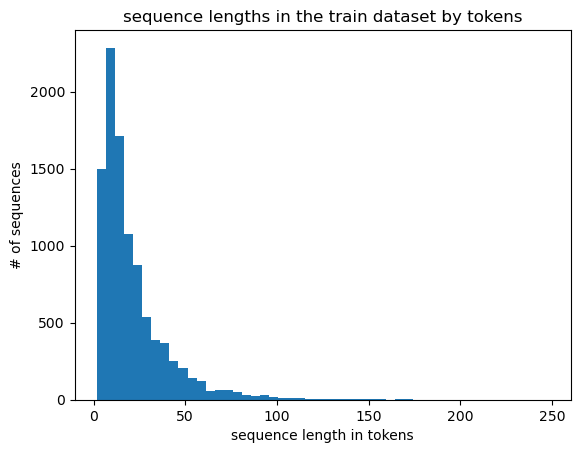

In [20]:
plt.hist([len(t) for t in tokens_train], bins=50)
plt.title("sequence lengths in the train dataset by tokens")
plt.ylabel("# of sequences")
plt.xlabel("sequence length in tokens")
plt.show()

In [21]:
# Notice above that the vast majority of sequences have less than 100 tokens.
# For performance we will thus truncate to 100 tokens.

MAX_LEN = 100
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

data_train = torch.tensor(
    [tokenize(t, MAX_LEN) for t in lines_train if len(t) > 0], dtype=torch.long
)
data_val = torch.tensor(
    [tokenize(t, MAX_LEN) for t in lines_dev if len(t) > 0], dtype=torch.long
)

data_train.shape, data_val.shape

(torch.Size([9875, 100]), torch.Size([1304, 100]))

In [22]:
# X is all but last token, Y is all but first token
train_dataset = torch.utils.data.TensorDataset(data_train[:, :-1], data_train[:, 1:])
val_dataset = torch.utils.data.TensorDataset(data_val[:, :-1], data_val[:, 1:])

# example X,Y pair from train dataset -- 2 is <START>, 3 is <STOP>
train_dataset[447]

(tensor([   0,   99,   50,   15, 1562,   12,  873, 1563,    6,    1,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3]),
 tensor([  99,   50,   15, 1562,   12,  873, 1563,    6,    1,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,

### Model and Trainer code

In [105]:
def get_model(num_layers: int):
    model_config = GPT.get_default_config()
    model_config.model_type = None
    model_config.pad_token = tokenizer["<PAD>"]
    
    # This configuration is the very small 'gpt-nano' defined in minGPT. we'd use a
    # bigger model like 'gpt2' but it would take a very long time to train :(
    # See minGPT/model.py for configurations of other models
    model_config.model_type = "gpt-nano"
    # 'gpt-nano' equivalent to:
    # model_config.n_layer = 3
    # model_config.n_head = 3
    # model_config.n_embd = 48
    
    model_config.vocab_size = max(tokenizer.values()) + 1
    # model_config.vocab_size = 50257 # openai's model vocabulary, if using gpt2 BPE
    
    # The model's context length
    # Note that minGPT has learned posemb, so outside the used maxlen wont really work
    model_config.block_size = 1024
    
    # We modified config to accept some functions for attention
    global NUM_LAYERS
    NUM_LAYERS = num_layers
    model_config.attn_init_fn = init_qkv_proj
    model_config.attn_fn = self_attention
    
    return GPT(model_config)

In [106]:
def train(model):
    log = []
    
    train_config = Trainer.get_default_config()
    train_config.device = DEVICE
    train_config.num_workers = 2
    
    # We didn't tune the hyperparameters at all, feel free to change
    train_config.learning_rate = 5e-4
    train_config.batch_size = 32
    train_config.max_iters = 3 * (
        len(train_dataset) // train_config.batch_size
    )  # train for 3 epochs
    
    trainer = Trainer(train_config, model, train_dataset)
    
    model.to(DEVICE)
    model.train()
    
    bar = tqdm(total=train_config.max_iters)
    
    @torch.no_grad()
    def on_batch_end(trainer):
        log.append(trainer.loss.item())
        bar.set_postfix(loss=trainer.loss.item())
        bar.update()
    
    trainer.set_callback("on_batch_end", on_batch_end)
    trainer.run()
    bar.close()
    return log

model = get_model(5)
print(model)
log = train(model)

number of parameters: 0.46M
GPT(
  (transformer): ModuleDict(
    (wte): Embedding(4622, 48)
    (wpe): Embedding(1024, 48)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-2): 3 x Block(
        (ln_1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_proj): Linear(in_features=48, out_features=48, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
          (W_Q): Sequential(
            (0): Linear(in_features=48, out_features=48, bias=True)
            (1): ReLU()
            (2): Linear(in_features=48, out_features=48, bias=True)
            (3): ReLU()
            (4): Linear(in_features=48, out_features=48, bias=True)
            (5): ReLU()
            (6): Linear(in_features=48, out_features=48, bias=True)
            (7): ReLU()
            (8): Linear(in_features=48, out_features=48, bias=True)
            (9): ReLU()
          

  0%|          | 0/924 [00:00<?, ?it/s]

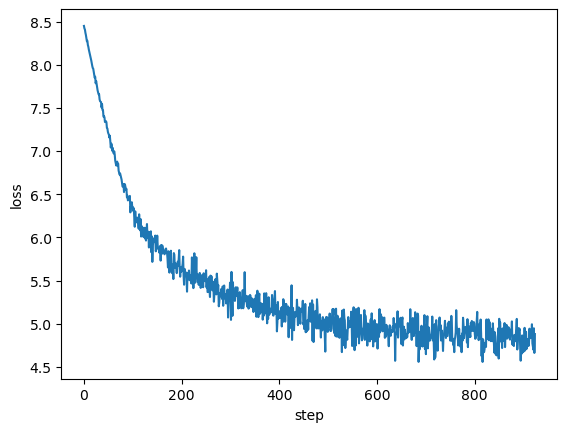

In [78]:
plt.plot(log)
plt.xlabel("step")
plt.ylabel("loss")
plt.show()

### Evaluation

Like in Project 1, we will treat each line in the data file as a separate document. So, compute perplexity for each line separately and then take the average across all lines.

However, the way we processed our data for batching makes it slightly more complicated, because the loss is averaged over tokens. While this would normally be simple, recall that we insert `<PAD>` tokens as padding until 100 tokens, and the vast majority of documents are significantly less than 100 tokens. This means that most of our tokens are the long tail of `<PAD>`s.

So, we wish to exlude every `<PAD>` from perplexity calculations. Since the loss returned by the model is averaged for all tokens. PyTorch has great utilities for excluding a padding token from calculations, but we will also do this manually as a demonstration.

However, this isn't the end of the story. Ideally, we would make `<PAD>` tokens have no effect whatsoever. For this to happen, we should apply a mask out all attention to and from `<PAD>` tokens, but we chose not to include that in your required implementation. The fact that we did not implement this has no measurable impact because our minGPT fork zeros out values for `<PAD>` tokens after attention anyway.

In [42]:
sentence = "Thank you so much Liwei and Taylor for all your help with this !"

tokens = torch.tensor([tokenize(sentence, pad_to_len=MAX_LEN)], dtype=torch.long)
X_tokens, y_tokens = tokens[:, :-1], tokens[:, 1:]

print("notice the long tail of PAD tokens: ", tokens.cpu()[0].tolist())

model.eval()
with torch.no_grad():
    logits, loss = model(X_tokens.to(DEVICE), y_tokens.to(DEVICE))
    logits, loss = logits.cpu(), loss.cpu()

# Preprocess logits to unpad -- will be (jagged) list of tensors
# We impl looping over them
# students have to: convert 1 document's raw logits + y_tokens into loss and ppl

# There's more ways to get the loss!

# We could use F.cross_entropy with the logits -- this is what the model does
# F.cross_entropy can take an "ignore_index", which makes it ignore our pad token
also_loss = F.cross_entropy(
    logits.flatten(0, 1), y_tokens.flatten(0, 1), ignore_index=tokenizer["<PAD>"]
)

# However, we can just do the calculations manually because we enjoy being perplexed

# softmax the logits to get probabilities
probs = F.softmax(logits, dim=-1)

# work with log of the probabilities for numerical stability
log_probs = torch.log(probs)

# this is weird pytorch screwery to index into last dimension of log_probs with y_tokens
# this selects only the log probabilities of the target tokens
y_log_probs = torch.gather(log_probs, -1, y_tokens[..., None])[..., 0]

# get all the target log probabilities EXCEPT for when that target token is <PAD>
not_pad_y_log_probs = y_log_probs[y_tokens != tokenizer["<PAD>"]]

# negative average of the log probs of the target tokens is exactly crossentropy loss here!
also_loss_again = -not_pad_y_log_probs.mean()

print()
print("reported loss from model:\t", loss.item())
print("manually calculated loss:\t", also_loss.item())
print("manually calculated loss again:\t", also_loss_again.item())

# we can calculate perplexity using the crossentropy loss
perplexity = torch.exp(also_loss)
print("perplexity:", perplexity.item())

notice the long tail of PAD tokens:  [0, 3257, 14, 39, 160, 2, 10, 2, 31, 44, 30, 382, 25, 33, 17, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

reported loss from model:	 4.394824028015137
manually calculated loss:	 4.394824028015137
manually calculated loss again:	 4.394824504852295
perplexity: 81.0303726196289


In [28]:
"""
We've made a utility function to calculate loss per-document for some data.
It accepts a list of strings, tokenizes, evaluates, and returns a list of floats.
"""

@torch.no_grad
def evaluate_losses(data, model=model, bs=32, progress=True, pad_to_len=MAX_LEN):
    it = range(0, len(data), bs)
    if progress:
        it = tqdm(it)

    out = []
    for b_start in it:
        batch = slice(b_start, b_start + bs)
        tokens = torch.tensor(
            [tokenize(t, pad_to_len=pad_to_len) for t in data[batch]], dtype=torch.long
        ).to(DEVICE)
        X_tokens, y_tokens = tokens[:, :-1].contiguous(), tokens[:, 1:].contiguous()

        model.eval()
        logits, _ = model(X_tokens)
        log_probs = F.log_softmax(logits, dim=-1)
        y_log_probs = torch.gather(log_probs, 2, y_tokens[..., None])[..., 0]

        for i in range(y_tokens.shape[0]):
            not_pad = y_tokens[i] != tokenizer["<PAD>"]
            loss = -y_log_probs[i, not_pad].mean()
            out.append(loss.item())

    return out

In [43]:
# calculate loss and perplexity for a single sentence
is_this_loss = evaluate_losses(
    [
        "RICHARD II : I will not be afraid of death . I will not be afraid of death .",
    ],
    progress=False,
)[0]
print("loss:", is_this_loss)
print("perplexity:", np.exp(is_this_loss))

loss: 4.669568061828613
perplexity: 106.6516655565906


In [44]:
train_losses = evaluate_losses(lines_train)
print("train perplexity:", np.mean(np.exp(train_losses)))

  0%|          | 0/309 [00:00<?, ?it/s]

train perplexity: 101.52460139191516


In [31]:
dev_losses = evaluate_losses(lines_dev)
print("dev perplexity:", np.mean(np.exp(dev_losses)))

  0%|          | 0/41 [00:00<?, ?it/s]

dev perplexity: 109.6068877280616


With the implementation on attention in Part 1, you should see that dev perplexity is close to the best perplexities that we achieved using N-gram models and interpolation in Project 1. The reason we don't do much better is that we are using a very small dataset and not doing much tuning. Transformer LMs become much more powerful when we have a whole lot of data.

Your task now is to make modifications to the attention mechanisms based on the guidelines in the handout and explore the effects of these changes.

In [45]:
# Here's an example of generating using the model -- see generate in minGPT's model.py

sentence = ""  # empty prompt -> sample from model at random
# sentence = 'unfortunately ,'          # can sample more negative stuff
# sentence = 'fun fact : did you know'  # AI-generated fun facts

tokens = torch.tensor([tokenize(sentence, include_stop=False)], dtype=torch.long).to(
    DEVICE
)

for _ in range(10):
    pred = model.generate(
        tokens, MAX_LEN - tokens.shape[-1], temperature=1.0, do_sample=True, top_k=None
    )

    print(decode(pred[0].tolist()))

<START> HASTINGS : Ay , But we lack he undergo to straight ; And a come ! <STOP>
<START> theme That brother . <STOP>
<START> YORK : ' the purpose him her <UNK> heart ; And more root , That To both not you have them than her little nobility as you : Who is rest . <STOP>
<START> <UNK> in more old great father , doth Ay . <STOP>
<START> Ready enemy , my had thou <UNK> lambs is not itself woman ; The victory , O Richard of good Though by what to kinsman of him long we Lies , heinous , By pledge my brother That a people , strengthen ' I wert ; And more , I say and <UNK> . <STOP>
<START> anointed daughter canst the bosom to this shepherd ; The breath again : We may stay : Somerset , Which As he makes 'd stir away Of those before your body can not the overthrow did not still Upon your <UNK> I would be so weep . <STOP>
<START> COMINIUS : proper head ? <STOP>
<START> Mowbray 's minute . <STOP>
<START> ISABELLA : I came , sir , Unless you do some service ! <STOP>
<START> QUEEN come and see the E

In [101]:
ex_model = get_model(5)
print(ex_model)

number of parameters: 0.46M
GPT(
  (transformer): ModuleDict(
    (wte): Embedding(4622, 48)
    (wpe): Embedding(1024, 48)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-2): 3 x Block(
        (ln_1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_proj): Linear(in_features=48, out_features=48, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
          (W_Q): Sequential(
            (0): Linear(in_features=48, out_features=48, bias=True)
            (1): ReLU()
            (2): Linear(in_features=48, out_features=48, bias=True)
            (3): ReLU()
            (4): Linear(in_features=48, out_features=48, bias=True)
            (5): ReLU()
            (6): Linear(in_features=48, out_features=48, bias=True)
            (7): ReLU()
            (8): Linear(in_features=48, out_features=48, bias=True)
            (9): ReLU()
          

In [100]:
layers = np.linspace(1, 30, 4, dtype=int)
perplexities = []
losses = []
models = []
for num_layers in layers:
    model = get_model(num_layers)
    final_loss = train(model)[-1]
    models.append(model)
    
    train_losses = evaluate_losses(lines_train, model)
    dev_losses = evaluate_losses(lines_dev, model)
    
    train_ppl = np.mean(np.exp(train_losses))
    dev_ppl = np.mean(np.exp(dev_losses))
    
    losses.append(final_loss)
    perplexities.append((train_ppl, dev_ppl))
    print(f"layers={num_layers}, final_loss={final_loss} train_ppl={train_ppl}, dev_ppl={dev_ppl}")

number of parameters: 0.38M
running on device cuda


  0%|          | 0/924 [00:00<?, ?it/s]

TypeError: 'NoneType' object is not callable

[(116.44851230213287, 105.20294944736361), (117.9182313334126, 107.55932110598835), (118.5086857216532, 107.6257179893562), (119.24224306518337, 110.4311909531677), (119.289452300641, 107.82115244085256), (118.46437783897119, 106.66145675268407), (118.9081180759405, 111.08754701535477), (117.48658304834069, 106.42502887739164), (117.80524942214976, 108.08361981099921), (117.79271442660632, 108.04399975314318)]


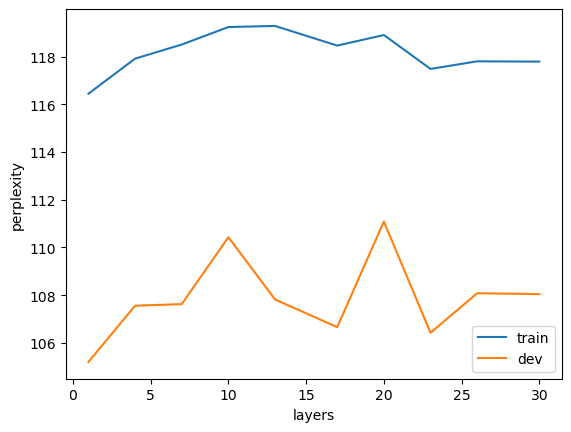

In [87]:
print(perplexities)
plt.plot(layers, [p[0] for p in perplexities], label="train")
plt.plot(layers, [p[1] for p in perplexities], label="dev")
plt.xlabel("layers")
plt.ylabel("perplexity")
plt.legend()
plt.show()

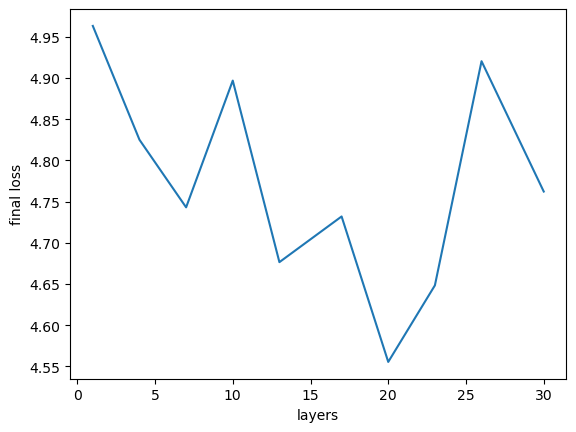

In [88]:
plt.plot(layers, losses)
plt.xlabel("layers")
plt.ylabel("final loss")
plt.show()


In [93]:
 # get 3 generations from each model
tokens = torch.tensor([tokenize("", include_stop=False)], dtype=torch.long).to(DEVICE)
for i, model in enumerate(models):
    print(f"layers = {layers[i]}")
    for _ in range(3):
        pred = model.generate(
            tokens, MAX_LEN - tokens.shape[-1], temperature=1.0, do_sample=True, top_k=None
        )

        print(decode(pred[0].tolist()))

layers = 1
<START> <UNK> from mine , to King It MOWBRAY : if honest very breath to your oath pronounced being sir , I would in the <UNK> Does Which fly , and hear that <UNK> enough ? <STOP>
<START> O lord ! and Clifford , hours of your hand , from and sir , Whither , as Leontes <UNK> . <STOP>
<START> farewell : disease 's the save for my loved him ; With poor <UNK> of us and in pay so , for the soften spirit and thy great help . <STOP>
layers = 4
<START> but he should go . <STOP>
<START> ROMEO MOWBRAY : Now , themselves ! <STOP>
<START> : hath not go <UNK> Thou contract that <UNK> queen . <STOP>
layers = 7
<START> How steal Thus if you <UNK> the <UNK> with as noble Aumerle . <STOP>
<START> BENVOLIO : I must have you , my Rome to court , Thou Will not let me , Which charge them <UNK> that speak to black own <UNK> . <STOP>
<START> May name is from him that he is by the remorse in my rather . <STOP>
layers = 10
<START> CLAUDIO : You told cold ' what , Would she is a houses 'd you done o'e